In [3]:
from google.colab import files
uploaded = files.upload()  # Opens a file upload prompt


Saving SMILES_retentionTime.csv to SMILES_retentionTime.csv


In [7]:
!pip install --upgrade sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from torch.utils.data import DataLoader, Dataset

# Load the dataset
data_pd = pd.read_csv('SMILES_retentionTime.csv')

# Load tokenizer and model
checkpoint = "JuIm/SMILES_BERT"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=1)  # Regression task

# Prepare the input sequences
sequences = data_pd['SMILES'].tolist()
retention_times = data_pd['retention_time'].values  # Retention time as target

# Tokenize SMILES sequences
model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

# Forward pass to get attention weights
with torch.no_grad():  # Disable gradient computation for efficiency
    outputs = model(**model_inputs, output_attentions=True)

# Extract the attention weights from the last layer
last_layer_attention = outputs.attentions[-1]  # Shape: (batch_size, num_heads, seq_len, seq_len)

# Convert retention times to a torch tensor
retention_times = torch.tensor(retention_times, dtype=torch.float32)

# Custom dataset for PyTorch DataLoader
class AttentionDataset(Dataset):
    def __init__(self, attention_weights, targets):
        self.attention_weights = attention_weights
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.attention_weights[idx], self.targets[idx]

# Create dataset and dataloaders
dataset = AttentionDataset(last_layer_attention, retention_times)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define a simple neural network model
class RetentionTimePredictor(nn.Module):
    def __init__(self, num_heads, seq_len):
        super(RetentionTimePredictor, self).__init__()
        self.conv1 = nn.Conv2d(num_heads, 32, kernel_size=3, padding=1)  # Convolution to extract patterns
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * seq_len * seq_len, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 1)  # Output layer for regression

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation, since it's regression
        return x

# Get dimensions from attention weights
batch_size, num_heads, seq_len, _ = last_layer_attention.shape

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RetentionTimePredictor(num_heads, seq_len).to(device)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        attention_batch, target_batch = batch
        attention_batch, target_batch = attention_batch.to(device), target_batch.to(device)

        optimizer.zero_grad()
        outputs = model(attention_batch)

        loss = criterion(outputs.squeeze(), target_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at JuIm/SMILES_BERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1/10, Loss: 98.2078
Epoch 2/10, Loss: 23.1954
Epoch 3/10, Loss: 21.2917
Epoch 4/10, Loss: 24.2472
Epoch 5/10, Loss: 19.0914
Epoch 6/10, Loss: 17.6088
Epoch 7/10, Loss: 15.0103
Epoch 8/10, Loss: 13.2097
Epoch 9/10, Loss: 10.7006
Epoch 10/10, Loss: 9.6330
Training complete!


In [2]:
model.eval()  # Set the model to evaluation mode


RetentionTimePredictor(
  (conv1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1166400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
import torch

# Tokenize the input SMILES sequences
model_inputs = tokenizer(data_pd['SMILES'].tolist(), padding=True, return_tensors="pt")
pretrained_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=1)  # Regression task


# Run the model without computing gradients
with torch.no_grad():
    outputs = pretrained_model(**model_inputs, output_attentions=True)

# Extract the attention weights (last layer)
last_layer_attention = outputs.attentions[-1]  # Shape: (batch_size, num_heads, seq_len, seq_len)

# Move to correct device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention_data = last_layer_attention.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at JuIm/SMILES_BERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Get model predictions
predicted_retention_times = model(attention_data).detach().cpu().numpy().flatten()


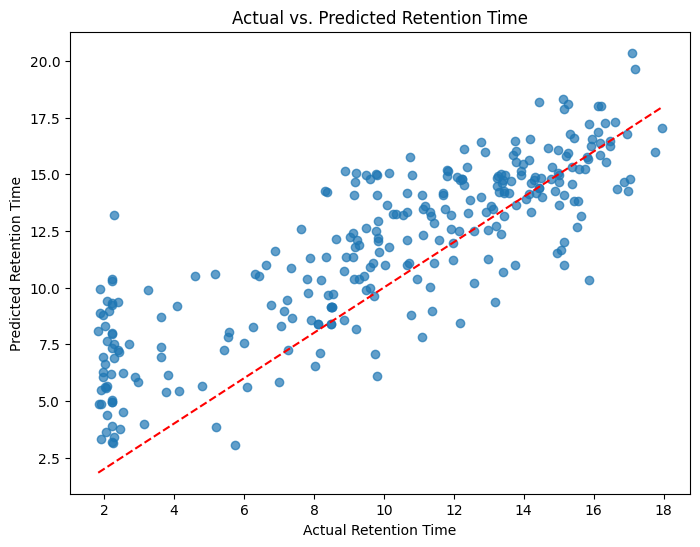

In [8]:
import matplotlib.pyplot as plt

# Get actual values
actual_retention_times = data_pd['retention_time'].values

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_retention_times, predicted_retention_times, alpha=0.7)
plt.xlabel("Actual Retention Time")
plt.ylabel("Predicted Retention Time")
plt.title("Actual vs. Predicted Retention Time")
plt.plot([min(actual_retention_times), max(actual_retention_times)],
         [min(actual_retention_times), max(actual_retention_times)],
         color='red', linestyle='--')  # Ideal fit line
plt.show()



In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_retention_times, predicted_retention_times)
mse = mean_squared_error(actual_retention_times, predicted_retention_times)
r2 = r2_score(actual_retention_times, predicted_retention_times)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 2.3899
Mean Squared Error (MSE): 9.3795
R² Score: 0.5715


In [4]:
import pandas as pd
data_pd = pd.read_csv("SMILES_retentionTime.csv")  # Adjust filename if needed
print(data_pd.head())  # Verify successful loading


                                              SMILES  retention_time
0                              [H][C@@](C)(NC)C(O)=O           10.80
1  NC(C1=C[N+]([C@@H]2O[C@@H]([C@H]([C@H]2O)O)COP...           15.80
2                            N[C@@H](CCC(N)=O)C(O)=O           12.79
3                                          NCCS(O)=O           11.74
4                           C[C@@H](O)[C@H](N)C(O)=O           12.08
